# 7T coil comparison: processing of phantom data

## Setup environment

In [1]:
# Imports
from datetime import datetime, timedelta
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.stats import iqr
import shutil
import zipfile
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
from pathlib import Path

# Define constants
GAMMA = 2.675e8;  # [rad / (s T)]

%matplotlib inline

start_time = datetime.now()

In [ ]:
# Download data from OpenNeuro ⏳

!openneuro-py download --dataset ds005090 --target-dir data-phantom/

In [2]:
# Define path (needs to be run in the root directory of the project)
path_data = os.path.join(os.getcwd(), "data-phantom/")
print(f"path_data: {path_data}")
path_labels = os.path.join(path_data, "derivatives", "labels")
path_qc = os.path.join(path_data, "qc")
subjects = [os.path.basename(subject_path) for subject_path in sorted(glob.glob(os.path.join(path_data, "sub-*")))]
print(f"subjects: {subjects}")
path_results = os.path.join(path_data, "derivatives", "results")

# Create results directory
os.makedirs(path_results, exist_ok=True)

path_data: /Users/evaalonsoortiz/Documents/Academic/Postdoc_NeuroPoly/Projects/THS_7T/coil-qc-code/data-phantom/
subjects: ['sub-CRMBM', 'sub-MGH', 'sub-MNI', 'sub-MPI', 'sub-MSSM', 'sub-NTNU', 'sub-UCL']


## Convert TFL and DREAM flip angle maps to B1+ in units of nT/V

In [ ]:
# Convert the TFL flip angle maps to B1+ efficiency maps [nT/V] (inspired by code from Kyle Gilbert)
# The approach consists in calculating the B1+ efficiency using a 1ms, pi-pulse at the acquisition voltage,
# then scale the efficiency by the ratio of the measured flip angle to the requested flip angle in the pulse sequence.

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))

    # Fetch the reference voltage from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
        metadata = json.load(f)
        ref_voltage = metadata.get("TxRefAmp", "N/A")
        if (ref_voltage == "N/A"):
            ref_token = "N/A"
            for token in metadata.get("SeriesDescription", "N/A").split("_"):
                if token.startswith("RefV"): ref_token = token
            ref_voltage = float(ref_token[4:-1])
        
    print(f"ref_voltage [V]: {ref_voltage} ({subject}_acq-famp_TB1TFL)")
                
    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1TFL.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        print(f"flip angle [degrees]: {requested_fa} ({subject}_acq-famp_TB1TFL)")

    # Open flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1TFL.nii.gz")
    meas_fa = nii.get_fdata()

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095

    # Compute B1 map in [T/V]
    # Siemens maps are in units of flip angle * 10 (in degrees)
    b1_map = ((meas_fa / 10) / requested_fa) * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))

    # Convert to [nT/V]
    b1_map = b1_map * 1e9

    # Save B1 map in [T/V] as NIfTI file
    nii_b1 = nib.Nifti1Image(b1_map, nii.affine, nii.header)
    nib.save(nii_b1, f"{subject}_TFLTB1map.nii.gz")

In [ ]:
# load DREAM FA maps acquired with different reference voltages
# threshold FA maps to 20deg < FA < 50deg
# combine FA maps by averaging non-zero estimates of FA in each pixel

voltages = ["1.5", "0.66"]

for subject in subjects:
    
    b1_maps = []
    os.chdir(os.path.join(path_data, subject, "fmap"))

    # Fetch the reference voltage from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
        metadata = json.load(f)
        ref_voltage = metadata.get("TxRefAmp", "N/A")
        if (ref_voltage == "N/A"):
            ref_token = "N/A"
            for token in metadata.get("SeriesDescription", "N/A").split("_"):
                if token.startswith("RefV"): ref_token = token
            ref_voltage = float(ref_token[4:-1])
    
    # Open refV flip angle map with nibabel
    nii = nib.load(f"{subject}_acq-famp_TB1DREAM.nii.gz")
    meas_fa = nii.get_fdata()
    #thresholding
    meas_fa[meas_fa < 200] = np.nan
    meas_fa[meas_fa > 500] = np.nan

    # Fetch the flip angle from the JSON sidecar 
    with open(f"{subject}_acq-famp_TB1DREAM.json", "r") as f:
        metadata = json.load(f)
        requested_fa = metadata.get("FlipAngle", "N/A")
        #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
        meas_fa = (meas_fa/10) / requested_fa

    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095
    # Compute B1 map in [T/V]
    b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
    # Convert to [nT/V]
    b1_map = b1_map * 1e9
    
    b1_maps.append(b1_map)

    for voltage in voltages:
        
        #check if map exists
        my_file = Path(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
        
        if my_file.is_file():
            
            # Fetch the reference voltage from the JSON sidecar 
            with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                metadata = json.load(f)
                ref_voltage = metadata.get("TxRefAmp", "N/A")
                if (ref_voltage == "N/A"):
                    ref_token = "N/A"
                    for token in metadata.get("SeriesDescription", "N/A").split("_"):
                        if token.startswith("RefV"): ref_token = token
                    ref_voltage = float(ref_token[4:-1])
                
            # Open flip angle map with nibabel
            nii = nib.load(f"{subject}_acq-famp-{voltage}_TB1DREAM.nii.gz")
            meas_fa = nii.get_fdata()
            #thresholding
            meas_fa[meas_fa < 200] = np.nan
            meas_fa[meas_fa > 500] = np.nan
        
            # Fetch the flip angle from the JSON sidecar 
            with open(f"{subject}_acq-famp-{voltage}_TB1DREAM.json", "r") as f:
                metadata = json.load(f)
                requested_fa = metadata.get("FlipAngle", "N/A")
                #convert measured FA to percent of requested FA (note that measured FA map is in degrees * 10)
                meas_fa = (meas_fa/10) / requested_fa
        else:
            meas_fa = np.full((nii.header).get_data_shape(),np.nan)

        # Account for the power loss between the coil and the socket. That number was given by Siemens.
        voltage_at_socket = ref_voltage * 10 ** -0.095
        # Compute B1 map in [T/V]
        # Siemens maps are in units of flip angle * 10 (in degrees)
        b1_map = meas_fa * (np.pi / (GAMMA * 1e-3 * voltage_at_socket))
        # Convert to [nT/V]
        b1_map = b1_map * 1e9
        
        b1_maps.append(b1_map)
 
    # compute mean of non-zero values
    avgB1=np.nanmean(b1_maps,axis=0)
    
    # Save as NIfTI file
    nii_avgB1 = nib.Nifti1Image(avgB1, nii.affine, nii.header)
    nib.save(nii_avgB1, f"{subject}_DREAMTB1avgB1map.nii.gz")

In [ ]:
# Split SNR data across multiple volumes. The first volume corresponds to the SoS SNR reconstruction, which is
#  what we will use for SNR comparison.
for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    !sct_image -i {subject}_acq-coilQaSagLarge_SNR.nii.gz -split t -o {subject}_acq-coilQaSagLarge_SNR.nii.gz

## Generate approximate mask of spinal cord

The purpose of this section is to generate an approximate mask of the spinal cord that will be used to quantify B1+ values inside the phantom. To do this, we identified a representative human subject, overlaid it on the anthropomorphic phantom, created a few pointwise labels along the spinal cord, interpolated those points using bsplines, and then created a cylindrical mask of 10mm diameter along the generated centerline.

![image](figures/spinalcord_mask_creation.png)

In [ ]:
os.chdir(os.path.join(path_data, "sub-CRMBM", "fmap"))

# Create labels on TFL B1+ map along an approximate spinal cord
! sct_label_utils -i "sub-CRMBM_acq-anat_TB1TFL.nii.gz" -create 49,108,23,1:49,99,23,1:49,88,23,1:50,76,23,1:55,63,23,1:62,51,23,1:68,35,23,1:72,26,23,1 -o "label_cord.nii.gz"
# Create spinal cord centerline
! sct_get_centerline -i "label_cord.nii.gz" -method fitseg -o "centerline_spinalcord.nii.gz"
# Create mask of 10mm diameter around centerline
! sct_create_mask -i "sub-CRMBM_acq-anat_TB1TFL.nii.gz" -p centerline,"centerline_spinalcord.nii.gz" -size 10mm -f cylinder -o "sub-CRMBM_TFLTB1map_mask.nii.gz"

## Co-register fmap data

The purpose of this section if to co-register phantom data across sites, to produce figures showing consistent placement of the phantom across sites, and to be able to use a single mask of the approximate spinal cord for quantitative analysis.

The co-registration uses programatically-created labels that correspond to the posterior tip of the phantom, at the inflexion point:

![image](figures/label_registration.png)

In [ ]:
# Create dictionary of labels across sites
labels_phantom_TFL = {
    'sub-CRMBM': '68,88,23',
    'sub-MGH': '61,98,26',
    'sub-MNI': '69,87,26',
    'sub-MPI': '67,95,27',
    'sub-MSSM': '73,65,28',
    'sub-NTNU': '64,96,29',
    'sub-UCL': '68,97,28',
}

# Define reference subject and suffix
subject_ref = 'sub-CRMBM'
suffix_ref = 'TFLTB1map'
suffixes = ["TFLTB1map", "DREAMTB1avgB1map", "acq-coilQaSagLarge_SNR_T0000"]

# Create labels for all suffixes, for all subjects
for subject in subjects:
    print(f"👉 CREATE LABELS FOR: {subject}")
    os.chdir(os.path.join(path_data, subject, "fmap"))
    !sct_label_utils -i {subject}_{suffix_ref}.nii.gz -create {labels_phantom_TFL[subject]},1 -o {subject}_{suffix_ref}_label.nii.gz
    # Register label from TFLTB1map to other metric using the qform matrix (ie: no optimization)
    for suffix in [other_suffixes for other_suffixes in suffixes if other_suffixes != suffix_ref]:
        !sct_register_multimodal -i {subject}_{suffix_ref}_label.nii.gz -d {subject}_{suffix}.nii.gz -identity 1
        !sct_apply_transfo -i {subject}_{suffix_ref}_label.nii.gz -d {subject}_{suffix}.nii.gz -w warp_{subject}_{suffix_ref}_label2{subject}_{suffix}.nii.gz -x label -o {subject}_{suffix}_label.nii.gz

# Register other scans to the reference scan
for subject in subjects:
    print(f"👉 REGISTER: {subject}")
    for suffix in suffixes:
        os.chdir(os.path.join(path_data, subject, "fmap"))
        # Perform registration
        !sct_register_multimodal -i {subject}_{suffix}.nii.gz -ilabel {subject}_{suffix}_label.nii.gz -d {path_data}{subject_ref}/fmap/{subject_ref}_{suffix}.nii.gz -dlabel {path_data}{subject_ref}/fmap/{subject_ref}_{suffix}_label.nii.gz -param step=0,type=label,dof=Tx_Ty_Tz:step=1,type=im,algo=syn,iter=0

# Register TFL B1+ spinal cord mask to DREAM and SNR reference scan
os.chdir(os.path.join(path_data, subject_ref, "fmap"))
for suffix in [other_suffixes for other_suffixes in suffixes if other_suffixes != suffix_ref]:
    !sct_register_multimodal -i {subject_ref}_{suffix_ref}_mask.nii.gz -d {subject_ref}_{suffix}.nii.gz -identity 1 -o {subject_ref}_{suffix}_mask.nii.gz

In [ ]:
# Generate syntax to open registered data in FSLeyes. This should be run from within the `data-phantom/` folder.
for suffix in suffixes:
    print(f"\n👉 CHECKING REGISTRATION FOR: {suffix}\n")
    cmd = f"fsleyes sub-CRMBM/fmap/sub-CRMBM_{suffix}.nii.gz"
    for subject in [other_subjects for other_subjects in subjects if other_subjects != subject_ref]:
        file_reg = os.path.join(path_data, subject, "fmap", f"{subject}_{suffix}_reg.nii.gz")
        cmd = f"{cmd} {file_reg}"
    # Add mask with color and opacity
    cmd = f"{cmd} sub-CRMBM/fmap/sub-CRMBM_{suffix}_mask.nii.gz --cmap yellow -a 30"
    print(cmd+" &")

# TODO: undisplay all scans but the first

## Extract values in mask and generate figures 

In [ ]:
# Extract B1+ and SNR along the spinal cord mask and save data to CSV files

for subject in subjects:
    os.chdir(os.path.join(path_data, subject, "fmap"))
    
    fname_result_TFLb1plus = os.path.join(path_results, f"{subject}_TFLTB1map.csv")
    fname_result_DREAMb1plus = os.path.join(path_results, f"{subject}_DREAMTB1avgB1map.csv")
    fname_result_SNR = os.path.join(path_results, f"{subject}_acq-coilQaSagLarge_SNR_T0000.csv")

    # For sites other than sub-CRMBM, use the registered qMRI map for metrics extraction
    if subject=='sub-CRMBM':
        file_suffix = ''
    else:
        file_suffix = '_reg'
        
    # Extract metrics within mask defined in the sub-CRMBM space
    !sct_extract_metric -i {subject}_TFLTB1map{file_suffix}.nii.gz -f ../../{subject_ref}/fmap/{subject_ref}_TFLTB1map_mask.nii.gz -method wa -z 19:127 -perslice 1 -o "{fname_result_TFLb1plus}"
    !sct_extract_metric -i {subject}_DREAMTB1avgB1map{file_suffix}.nii.gz -f ../../{subject_ref}/fmap/{subject_ref}_DREAMTB1avgB1map_mask.nii.gz -method wa -z 14:62 -perslice 1 -o "{fname_result_DREAMb1plus}"
    !sct_extract_metric -i {subject}_acq-coilQaSagLarge_SNR_T0000{file_suffix}.nii.gz -f ../../{subject_ref}/fmap/{subject_ref}_acq-coilQaSagLarge_SNR_T0000_mask.nii.gz -method wa -z 151:368 -perslice 1 -o "{fname_result_SNR}"

## Correct SNR using B1+ values

SNR depends on the effective flip angle at each voxel, which is influenced by the B1+ efficiency and the transmit homogeneity. Therefore, if we want to report SNR values independently of the actual flip angle played out, we need to correct the SNR maps. To do so, we divide the reconstructed SNR maps by $\sin(\text{FA}_{\text{gre, meas}})$, where $\text{FA}_{\text{gre, meas}}$ is the actual flip angle map for the GRE SNR scan. By normalizing, we extrapolate to the SNR value that we would achieve with $ \text{FA} = 90^\circ $:

$$\text{SNR}_{90} = \frac{\text{SNR}_{\text{meas}}}{\sin(\text{FA}_{\text{gre, meas}})}$$

$\text{FA}_{\text{gre, meas}}$ is computed from the TFL B1+ scan as follows: 

$$\text{FA}_{\text{gre, meas}} = \text{FA}_{\text{gre, requested}} \times \left( \frac{\text{FA}_{\text{TFL, meas}}}{\text{FA}_{\text{TFL, requested}}} \right)$$

The ratio $\frac{\text{FA}_{\text{TFL, meas}}}{\text{FA}_{\text{TFL, requested}}}$ is obtained from the TFL B1+ efficiency values, which were previously extracted slicewise and saved as a CSV file.

Before doing this correction, given that the B1+ and SNR maps don't have the same spatial resolution, we need to interpolate the B1+ array to match its length with that of the SNR array.

Reference: https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.27695

In [ ]:
for subject in subjects:
    
    fname_result_TFLb1plus = os.path.join(path_results, f"{subject}_TFLTB1map.csv")
    fname_result_SNR = os.path.join(path_results, f"{subject}_acq-coilQaSagLarge_SNR_T0000.csv")
    fname_result_SNR_corrected = os.path.join(path_results, f"{subject}_acq-coilQaSagLarge_SNR_T0000_corrected.csv")

    # INTERPOLATE B1+ MAP TO MATCH THE LENGTH OF THE SNR DATA
    # =======================================================
    # Read B1 values
    df_b1 = pd.read_csv(fname_result_TFLb1plus)
    b1_map = df_b1["WA()"].values
    # Read SNR values
    df_snr = pd.read_csv(fname_result_SNR)
    snr = df_snr["WA()"].values
    # Create interpolation function based on the length of snr
    x = np.linspace(0, len(b1_map) - 1, len(b1_map))  # x values for original data points
    f = interp1d(x, b1_map, kind='linear')
    # Generate new x values to match the length of the `snr` array
    x_new = np.linspace(0, len(b1_map) - 1, len(snr))
    # Interpolate to get the new y values with the length of `snr`
    b1_map_interp = f(x_new)

    # CORRECT SNR VALUES FOR B1+ INHOMOGENEITY
    # ========================================
    # Fetch the reference voltage for the TFL scan
    # TODO: create a function for this
    with open(os.path.join(path_data, subject, "fmap", f"{subject}_acq-famp_TB1TFL.json"), "r") as f:
        metadata = json.load(f)
        ref_voltage = metadata.get("TxRefAmp", "N/A")
        if (ref_voltage == "N/A"):
            ref_token = "N/A"
            for token in metadata.get("SeriesDescription", "N/A").split("_"):
                if token.startswith("RefV"): ref_token = token
            ref_voltage = float(ref_token[4:-1])
    # Fetch the flip angle for the TFL scan
    with open(os.path.join(path_data, subject, "fmap", f"{subject}_acq-famp_TB1TFL.json"), "r") as f:
        metadata = json.load(f)
        requested_fa_tfl = metadata.get("FlipAngle", "N/A")
    # Account for the power loss between the coil and the socket. That number was given by Siemens.
    voltage_at_socket = ref_voltage * 10 ** -0.095
    # measured-to-requested flip angle using B1 values (in nT/V)
    meas_to_requested_fa = 10 * b1_map_interp * GAMMA * 1e-3 * voltage_at_socket / (np.pi * 1e9)
    # Fetch the requested flip angle for the SNR GRE scan
    with open(os.path.join(path_data, subject, "fmap", f"{subject}_acq-coilQaSagLarge_SNR.json"), "r") as f:
        metadata = json.load(f)
        requested_fa_gre = metadata.get("FlipAngle", "N/A")
    # Correct the SNR values for B1+ inhomogeneity
    snr_corrected = snr / np.sin(np.deg2rad(requested_fa_gre * meas_to_requested_fa))
    # Save corrected SNR values to CSV
    df_snr_corrected = pd.DataFrame(snr_corrected)
    # Insert 'WA()' as the first value in the DataFrame
    df_snr_corrected.loc[-1] = ['WA()'] + [None] * (df_snr_corrected.shape[1] - 1)  # Prepend 'WA()' to the first column
    df_snr_corrected.index = df_snr_corrected.index + 1  # Shift index
    df_snr_corrected = df_snr_corrected.sort_index()  # Sort index to move the new row to the top
    # Save corrected SNR values to CSV
    df_snr_corrected.to_csv(fname_result_SNR_corrected, index=False, header=False)

## Generate figures

### g-factor maps

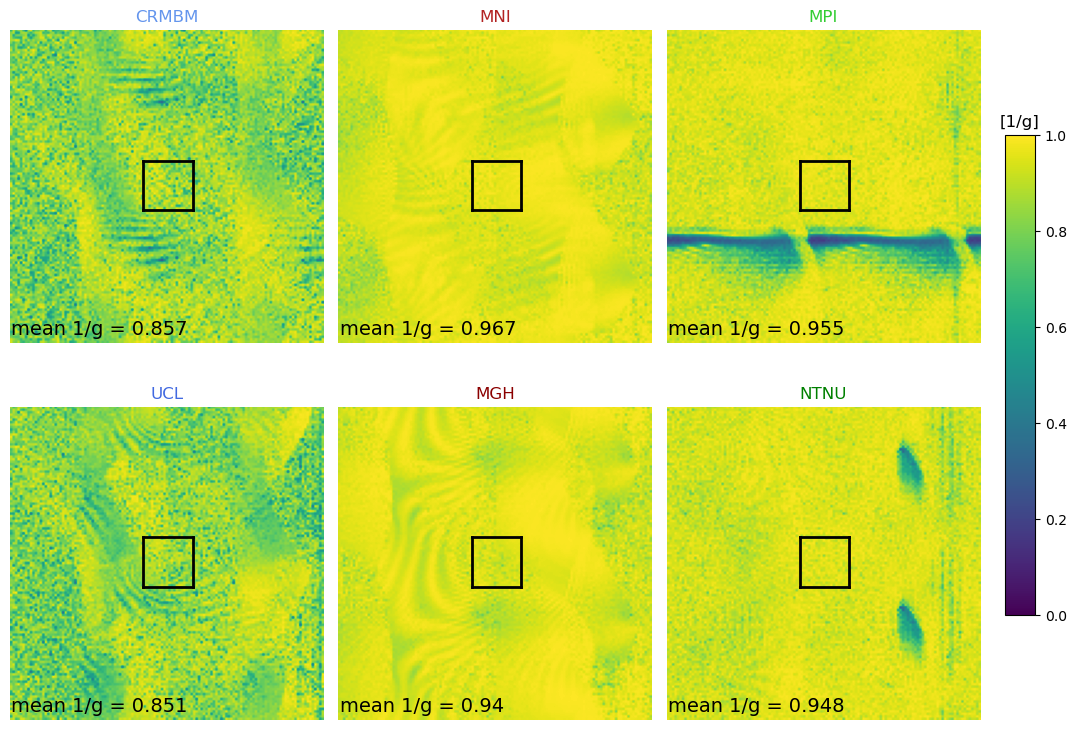

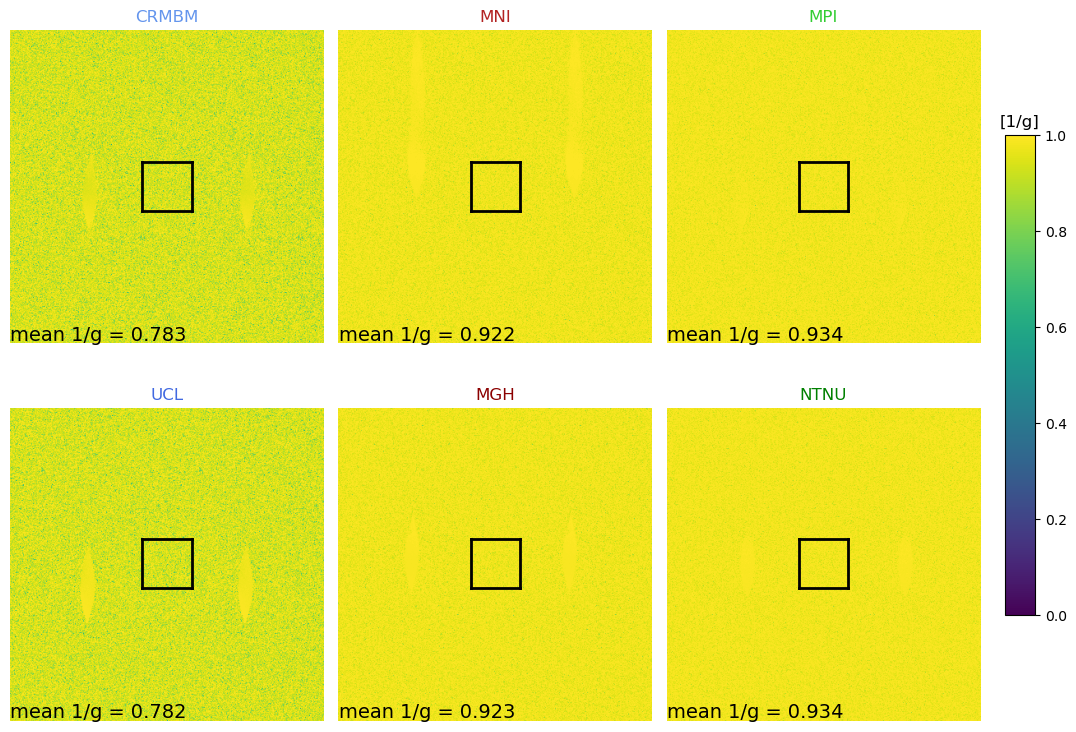

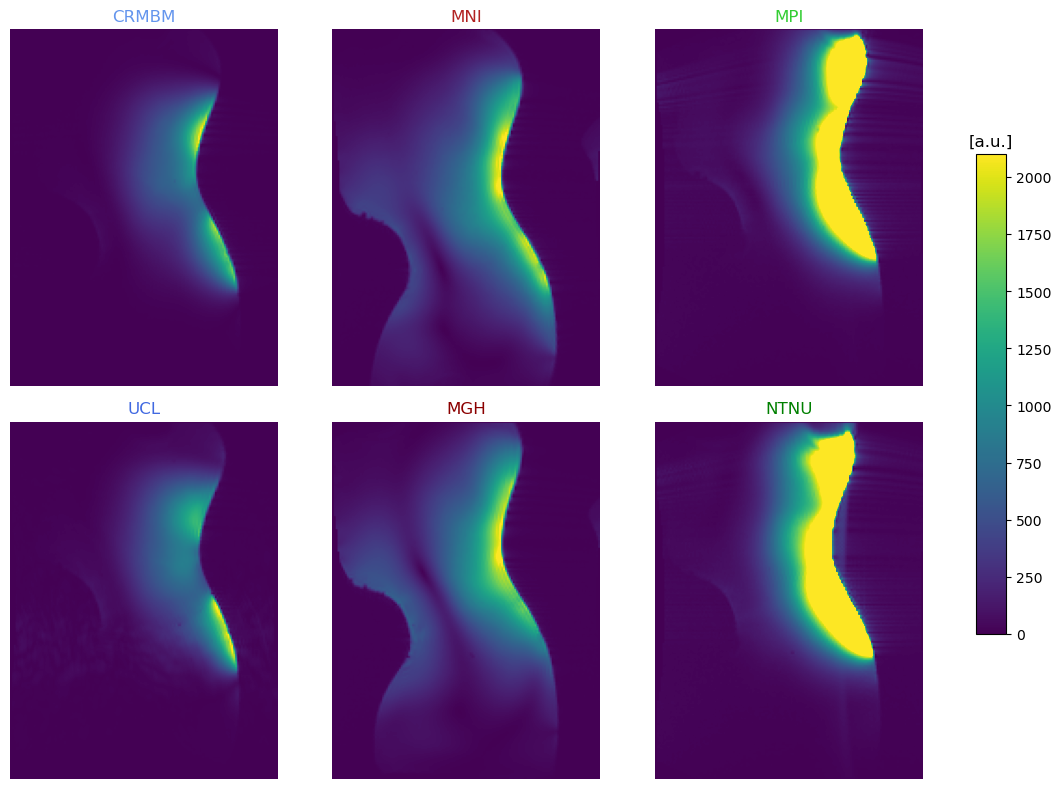

In [4]:

# Compute the average and maximum 1/g factor in a central ROI
# Display 1/g factor maps and T2w (coil-combined) maps for each site (MSSM excluded, see: https://github.com/spinal-cord-7t/coil-qc-code/issues/61)

sites = ["CRMBM", "MNI", "MPI", "UCL", "MGH", "NTNU"] # MSSM excluded, see: https://github.com/spinal-cord-7t/coil-qc-code/issues/61
site_colors = ['cornflowerblue', 'firebrick', 'limegreen', 'royalblue', 'darkred', 'green']

# map types
map_types = ["acq-coilQaSagSmall_GFactor", "acq-coilQaTra_GFactor", "T2starw"]
# legend types
legend_types = ["[1/g]", "[1/g]", "[a.u.]"]

mean_gfac = {}

for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))
    font_size = 12
    axes=axes.flatten() 
        
    for i,site in enumerate(sites):
        # T2starw
        if map_type=="T2starw":
            os.chdir(os.path.join(path_data, f"sub-{site}", "anat"))
            map=nib.load(f"sub-{site}_{map_type}.nii.gz")
            data=map.get_fdata()[:,:,round(map.get_fdata().shape[2]/2)]
        # g-factor maps
        else:
            os.chdir(os.path.join(path_data, f"sub-{site}", "fmap"))
            map=nib.load(f"sub-{site}_{map_type}.nii.gz")
            if map_type=="acq-coilQaSagSmall_GFactor":   
                data=(map.get_fdata()[64:191,64:191,round(map.get_fdata().shape[2]/2),5])/1000
                gfac_data=(map.get_fdata()[round(map.get_fdata().shape[0]/2)-10:round(map.get_fdata().shape[0]/2)+10,round(map.get_fdata().shape[1]/2)-10:round(map.get_fdata().shape[1]/2)+10,round(map.get_fdata().shape[2]/2),5])
            else:
                data=(map.get_fdata()[192:574,192:574,round(map.get_fdata().shape[2]/2),0])/1000
                gfac_data=(map.get_fdata()[round(map.get_fdata().shape[0]/2)-30:round(map.get_fdata().shape[0]/2)+30,round(map.get_fdata().shape[1]/2)-30:round(map.get_fdata().shape[1]/2)+30,round(map.get_fdata().shape[2]/2),5])
            
            mean_gfac[site]=np.nanmean(gfac_data)/1000
        
        # Plot    
        splot=axes[i]
        dynmin = 0
        if map_type=="T2starw":
            dynmax = 2100
            axes[-1].axis('off')
        else:
            dynmax = 1
            axes[-1].axis('off')
            splot.text(0, 3, r'mean 1/g = '+str(round(mean_gfac[site],3)), size=14)
            
            if map_type=="acq-coilQaSagSmall_GFactor": 
                x = [data.shape[0]/2-10, data.shape[1]/2-10] 
                y = [data.shape[0]/2-10, data.shape[1]/2+10] 
                splot.plot(x, y, color="black", linewidth=2) 
                
                x = [data.shape[0]/2-10, data.shape[1]/2+10] 
                y = [data.shape[0]/2+10, data.shape[1]/2+10] 
                splot.plot(x, y, color="black", linewidth=2) 
    
                x = [data.shape[0]/2+10, data.shape[1]/2+10] 
                y = [data.shape[0]/2+10, data.shape[1]/2-10] 
                splot.plot(x, y, color="black", linewidth=2)
    
                x = [data.shape[0]/2+10, data.shape[1]/2-10] 
                y = [data.shape[0]/2-10, data.shape[1]/2-10] 
                splot.plot(x, y, color="black", linewidth=2) 
            else:
                x = [data.shape[0]/2-30, data.shape[1]/2-30] 
                y = [data.shape[0]/2-30, data.shape[1]/2+30] 
                splot.plot(x, y, color="black", linewidth=2) 
                
                x = [data.shape[0]/2-30, data.shape[1]/2+30] 
                y = [data.shape[0]/2+30, data.shape[1]/2+30] 
                splot.plot(x, y, color="black", linewidth=2) 
    
                x = [data.shape[0]/2+30, data.shape[1]/2+30] 
                y = [data.shape[0]/2+30, data.shape[1]/2-30] 
                splot.plot(x, y, color="black", linewidth=2)
    
                x = [data.shape[0]/2+30, data.shape[1]/2-30] 
                y = [data.shape[0]/2-30, data.shape[1]/2-30] 
                splot.plot(x, y, color="black", linewidth=2) 
        
        im = splot.imshow((data.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax) 
        splot.set_title(site, size=font_size, color=site_colors[i])
        splot.axis('off')

    plt.tight_layout()

    # Colorbar
    # Assume that the colorbar should start at the bottom of the lower row of subplots and
    # extend to the top of the upper row of subplots
    cbar_bottom = 0.2  # This might need adjustment
    cbar_height = 0.6  # This represents the total height of both rows of subplots
    cbar_dist = 1.01
    cbar_ax = fig.add_axes([cbar_dist, cbar_bottom, 0.03, cbar_height])
    cbar = plt.colorbar(im, cax=cbar_ax)

    cbar_ax.set_title(legend_type, size=12)
    plt.show()


### B1+ and SNR maps

In [ ]:
sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]
colors = ['cornflowerblue', 'royalblue', 'firebrick', 'darkred', 'limegreen', 'green', 'mediumpurple']

# map types
map_types = ["TFLTB1map", "DREAMTB1avgB1map", "acq-coilQaSagLarge_SNR_T0000"]

# Define the dictionary with ranges for each map type
# NIfTI voxel location: (xmin, xmax, ymin, ymax, zdata, zmask)
range_dict = {
    "TFLTB1map": (19, 83, 21, 122, 23, 23),
    "DREAMTB1avgB1map": (18, 79, 14, 62, 5, 5),
    "acq-coilQaSagLarge_SNR_T0000": (217, 317, 176, 335, 6, 6),
}

# legend types
legend_types = ["B1+ [nT/V]", "B1+ [nT/V]", "SNR [a.u.]"]

for map_type, legend_type in zip(map_types,legend_types):
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 8))
    font_size = 12
    axes=axes.flatten() 
        
    for i,site in enumerate(sites):
        # Load data
        os.chdir(os.path.join(path_data, f"sub-{site}", "fmap"))
        if site=='CRMBM':
            map=nib.load(f"sub-{site}_{map_type}.nii.gz")
            if map_type=="TFLTB1map":
                mask=nib.load(f"sub-CRMBM_TFLTB1map_mask.nii.gz")
            elif map_type=="DREAMTB1avgB1map":
                mask=nib.load(f"sub-CRMBM_DREAMTB1avgB1map_mask.nii.gz")
            else: 
                mask=nib.load(f"sub-CRMBM_acq-coilQaSagLarge_SNR_T0000_mask.nii.gz")
        else:
            map=nib.load(f"sub-{site}_{map_type}_reg.nii.gz")
            if map_type=="TFLTB1map":
                mask=nib.load(f"../../sub-CRMBM/fmap/sub-CRMBM_TFLTB1map_mask.nii.gz")
            elif map_type=="DREAMTB1avgB1map":
                mask=nib.load(f"../../sub-CRMBM/fmap/sub-CRMBM_DREAMTB1avgB1map_mask.nii.gz")
            else: 
                mask=nib.load(f"../../sub-CRMBM/fmap/sub-CRMBM_acq-coilQaSagLarge_SNR_T0000_mask.nii.gz")

        # Crop data for display
        data = map.get_fdata()[
            range_dict[map_type][0]:range_dict[map_type][1],
            range_dict[map_type][2]:range_dict[map_type][3],
            range_dict[map_type][4]]
        mask_data = mask.get_fdata()[
            range_dict[map_type][0]:range_dict[map_type][1],
            range_dict[map_type][2]:range_dict[map_type][3],
            range_dict[map_type][5]]

        # Binarize mask for display purpose
        mask_data = (mask_data > 0.5).astype(int)
        
        # Plot
        dynmin = 0 
        if map_type=="acq-coilQaSagLarge_SNR_T0000":
            dynmax = 310
        else:
            dynmax = 75    
            
        splot=axes[i]
        im1 = splot.imshow((data.T), cmap='viridis', origin='lower',vmin=dynmin,vmax=dynmax)
        # im2 = splot.imshow((mask_data.T), 'gray', origin='lower', alpha=0.2)
        splot.contour(mask_data.T, levels=[0.5], colors='white', linewidths=0.5)
        splot.set_title(site, size=font_size,c=colors[i])
        splot.axis('off')    
    
    # Display mean signal within mask for each site in an additional sub-plot
    for site,color in zip(sites,colors):
        # Read CSV file
        if map_type == "acq-coilQaSagLarge_SNR_T0000":
            file_csv = os.path.join(path_results, f"sub-{site}_{map_type}_corrected.csv")
        else:
            file_csv = os.path.join(path_results, f"sub-{site}_{map_type}.csv")
        df = pd.read_csv(file_csv)
        data = df['WA()'].dropna()
        # Smooth data
        data = uniform_filter1d(data, 10, mode='nearest')
        # Display plot
        axes[-1].plot(data, label=site, c=color)
        axes[-1].legend(fontsize=10, loc='center left', bbox_to_anchor=(1.2, 0.5))
        axes[-1].yaxis.set_label_position("right")
        axes[-1].yaxis.tick_right()
        axes[-1].set_xticks([])  # Remove x-axis ticks
        axes[-1].set_xlabel("← superior    inferior →", fontsize=12, loc='center')
        # axes[-1].set_yticks([])  # Remove y-axis ticks
        axes[-1].invert_xaxis()  # Reverse the x-axis
        axes[-1].yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5)

    # Reduce the space between the rows of subplots
    fig.subplots_adjust(hspace=-0.2)  # Adjust this value as needed to reduce spacing

    # Adjust figure subplots
    plt.tight_layout()
    box = axes[-1].get_position()
    new_height = box.height * 0.76  # Reduce the height of the second subplot by 50%
    axes[-1].set_position([box.x0, box.y0 + 0.068, box.width, new_height])

    # Colorbar
    cbar_bottom = 0.545  # This might need adjustment
    cbar_height = 0.37  # This represents the total height of both rows of subplots
    if (map_type == "TFLTB1map" or map_type == "DREAMTB1avgB1map" or map_type == "acq-coilQaSagLarge_SNR_T0000"):
        cbar_dist = -0.1
    else:
        cbar_dist = 1.01
    cbar_ax = fig.add_axes([0.9, cbar_bottom, 0.02, cbar_height])
    cbar = plt.colorbar(im1, cax=cbar_ax)
    cbar_ax.set_title(legend_type, size=10)
    
    plt.show()

### Individual coil channels

In [ ]:
sites = ["CRMBM", "UCL", "MNI", "MGH", "MPI", "NTNU", "MSSM"]
        
for i,site in enumerate(sites):

    gre_files=sorted(glob.glob(os.path.join(path_data, f"sub-{site}", "anat", '*uncombined*.nii.gz')))
        
    #Tiled figure in a five-row layout
    rows=int(np.ceil(len(gre_files)/4))
    cols=int(np.ceil(len(gre_files)/rows))

    fig=plt.figure(figsize=(15, 20))
    
    ax = fig.subplots(rows,cols,squeeze=True)
    
    for row in range(rows):
        for col in range(cols):

            i = row*cols+col

            if i < len(gre_files):
            
                #read in files
                data_to_plot=(nib.load(gre_files[i])).get_fdata() #load in nifti object, get only image data
                data_to_plot=np.rot90(data_to_plot[:,:,int(np.floor(data_to_plot.shape[2]/2))]) #central slice
           
                ax[row,col].imshow(data_to_plot,cmap=plt.cm.gray,clim=[0, 300])
                ax[row,col].text(0.5, 0.05, 'Rx channel : ' + str(i+1),horizontalalignment='center', transform=ax[row,col].transAxes,color='white',fontsize=17)
                ax[row,col].axis('off')

    plt.axis('off')
    plt.subplots_adjust(hspace=0,wspace=0)
    fig.suptitle(site, fontsize=20, y=0.9)


## Finished

In [ ]:
# Indicate duration of data processing

end_time = datetime.now()
total_time = (end_time - start_time).total_seconds()

# Convert seconds to a timedelta object
total_time_delta = timedelta(seconds=total_time)

# Format the timedelta object to a string
formatted_time = str(total_time_delta)

# Pad the string representation if less than an hour
formatted_time = formatted_time.rjust(8, '0')

print(f"Total Runtime [hour:min:sec]: {formatted_time}")